In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output
from gym_stock_trading_env import StockTradingEnv
from functions.strategy import *
from functions.position_size import *
from functions.risk_management import *
from functions.reward_functions import *
from functions.transaction_cost import *
from functions.other_utils import *
from Reinforcement_learning.DRL_agent import *

In [2]:
def real_time_render_with_decisions(env, decision_history):
    """
    Displays a two-panel plot:
      - Upper panel: Price chart (zoomed-in view or full view) with trade markers.
      - Lower panel: Agent decisions over time (0: Hold, 1: Buy, 2: Sell) as colored scatter points.
    """
    clear_output(wait=True)
    
    # Update total asset value with latest price.
    current_price = float(env.df.loc[env.current_step, 'Close'])
    env.total_asset_value = env.balance + env.num_shares * current_price

    zoom_window = 30
    current = env.current_step
    
    # Determine plotting window.
    if current < env.max_steps:
        start_idx = max(0, current - zoom_window)
        end_idx = current + 1
    else:
        start_idx = 0
        end_idx = len(env.df)
    
    # Price data for upper subplot.
    x_data = range(start_idx, end_idx)
    y_data = env.df['Close'].iloc[start_idx:end_idx].values
    
    # Create figure with two subplots.
    plt.figure(figsize=(12, 8))
    
    # Upper subplot: Price chart.
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x_data, y_data, label='Close Price', color='blue', linewidth=2)
    ax1.scatter(current, current_price, color='orange', marker='o', s=150, label='Current Price')
    
    # Plot trade markers.
    buys = [t for t in env.trade_history if t['action'] == 'buy' and start_idx <= t['step'] < end_idx]
    sells = [t for t in env.trade_history if t['action'] == 'sell' and start_idx <= t['step'] < end_idx]
    
    if buys:
        buy_steps = [t['step'] for t in buys]
        buy_prices = [t['price'] for t in buys]
        ax1.scatter(buy_steps, buy_prices, color='green', marker='^', s=120, label='Buy')
        for bs, bp, trade in zip(buy_steps, buy_prices, buys):
            annotation = f"{bp:.2f} ({trade['quantity']})"
            ax1.annotate(annotation, (bs, bp), textcoords="offset points", xytext=(0, 5), ha='center', color='green')
    if sells:
        sell_steps = [t['step'] for t in sells]
        sell_prices = [t['price'] for t in sells]
        ax1.scatter(sell_steps, sell_prices, color='red', marker='v', s=120, label='Sell')
        for ss, sp, trade in zip(sell_steps, sell_prices, sells):
            annotation = f"{sp:.2f} ({trade['quantity']})"
            ax1.annotate(annotation, (ss, sp), textcoords="offset points", xytext=(0, -10), ha='center', color='red')
    
    ax1.set_title(f"Step: {env.current_step} | Balance: {env.balance:.2f} | Shares: {env.num_shares} | Total Asset: {env.total_asset_value:.2f}")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Price")
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Lower subplot: Agent decision history.
    ax2 = plt.subplot(2, 1, 2)
    if decision_history:
        steps, actions = zip(*decision_history)
        # Map actions to colors: Hold=blue, Buy=green, Sell=red.
        colors = ['blue' if a==0 else 'green' if a==1 else 'red' for a in actions]
        ax2.scatter(steps, actions, c=colors, s=100)
        ax2.set_ylim(-0.5, 2.5)
        ax2.set_xlabel("Time Step")
        ax2.set_ylabel("Action (0: Hold, 1: Buy, 2: Sell)")
        ax2.set_title("Agent Decisions Over Time")
    else:
        ax2.text(0.5, 0.5, 'No Decisions Yet', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    time.sleep(0.1)

In [3]:
def custom_render(env):
    clear_output(wait=True)
    
    current_price = float(env.df.loc[env.current_step, 'Close'])
    env.total_asset_value = env.balance + env.num_shares * current_price
    
    zoom_window = 30
    current = env.current_step
    
    if current < env.max_steps:
        start_idx = max(0, current - zoom_window)
        end_idx = current + 1
    else:
        start_idx = 0
        end_idx = len(env.df)
    
    x_data = range(start_idx, end_idx)
    y_data = env.df['Close'].iloc[start_idx:end_idx].values

    plt.figure(figsize=(12, 6))
    plt.plot(x_data, y_data, label='Close Price', color='blue', linewidth=2)
    
    plt.scatter(current, current_price, color='orange', marker='o', s=150, label='Current Price')
    
    buys = [t for t in env.trade_history if t['action'] == 'buy' and start_idx <= t['step'] < end_idx]
    sells = [t for t in env.trade_history if t['action'] == 'sell' and start_idx <= t['step'] < end_idx]
    
    if buys:
        buy_steps = [t['step'] for t in buys]
        buy_prices = [t['price'] for t in buys]
        plt.scatter(buy_steps, buy_prices, color='green', marker='^', s=120, label='Buy')
        for bs, bp, trade in zip(buy_steps, buy_prices, buys):
            annotation = f"{bp:.2f} ({trade['quantity']})"
            plt.annotate(annotation, (bs, bp), textcoords="offset points", xytext=(0, 5), ha='center', color='green')
    
    if sells:
        sell_steps = [t['step'] for t in sells]
        sell_prices = [t['price'] for t in sells]
        plt.scatter(sell_steps, sell_prices, color='red', marker='v', s=120, label='Sell')
        for ss, sp, trade in zip(sell_steps, sell_prices, sells):
            annotation = f"{sp:.2f} ({trade['quantity']})"
            plt.annotate(annotation, (ss, sp), textcoords="offset points", xytext=(0, -10), ha='center', color='red')
    
    title = f"Step: {env.current_step} | Balance: {env.balance:.2f} | Shares: {env.num_shares} | Total Asset: {env.total_asset_value:.2f}"
    plt.title(title, fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    time.sleep(0.1)

In [4]:
df = yf.download("AAPL", start="2021-01-01", end="2023-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-01-04,126.405228,130.507705,123.816757,130.419798,143301900
2021-01-05,127.968071,128.681132,125.447974,125.897300,97664900
2021-01-06,123.660484,128.007165,123.445591,124.754482,155088000
2021-01-07,127.880157,128.573678,124.891210,125.379601,109578200
2021-01-08,128.983948,129.550483,127.206199,129.355114,105158200
...,...,...,...,...,...
2022-12-23,130.344482,130.898044,128.149997,129.415284,63814900
2022-12-27,128.535522,129.899667,127.240581,129.870013,69007800


In [6]:
env = StockTradingEnv(df, initial_balance=10000, transaction_cost_pct=0.001, custom_render=custom_render)

c:\Users\mikol\OneDrive\Pulpit\Projekty_prywatne\Stock-trading-Reinforcement-Learning\gym_stock_trading_env.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.df.loc[self.current_step, 'Close'])


In [7]:
# Choose a strategy
strategy = ExtremaStrategy(window=3)

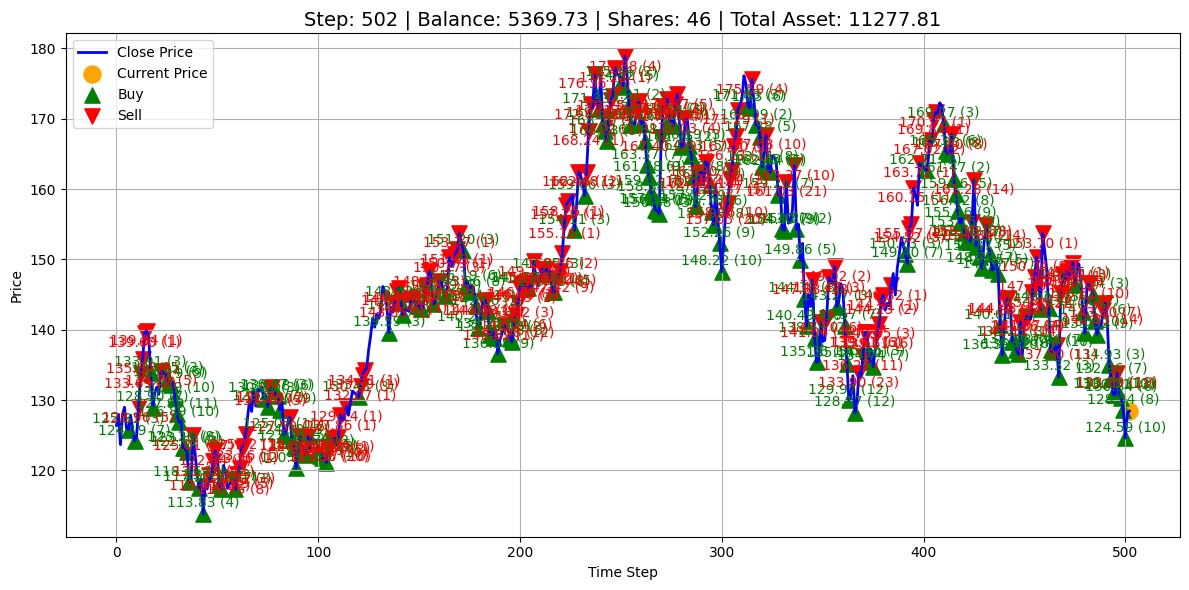

In [8]:
# Reset the environment.
obs = env.reset()
done = False
step = 0

while not done:
    # Transform the state.
    state = state_transformation(obs)
    
    # Get the action from the chosen strategy.
    action = strategy.get_action(env)
    
    # Determine position sizing.
    quantity = scale_in_position_sizing(state, env, action, base_fraction=0.05)
    
    # Risk management.
    action, quantity = max_loss_risk_management(state, env, action, quantity)
    
    # Transaction cost adjustments.
    quantity = transaction_cost_function(state, env, action, quantity)
    
    # Execute the step.
    obs, raw_reward, done, info = env.step((action, quantity))
    
    # Compute final reward.
    final_reward = reward_function(state, env, raw_reward, info)
    
    # Logging.
    logging_callback(step, state, action, quantity, final_reward, info)
    
    # Render the updated plot.
    env.render()
    
    step += 1

Deep reinforcement learning approach

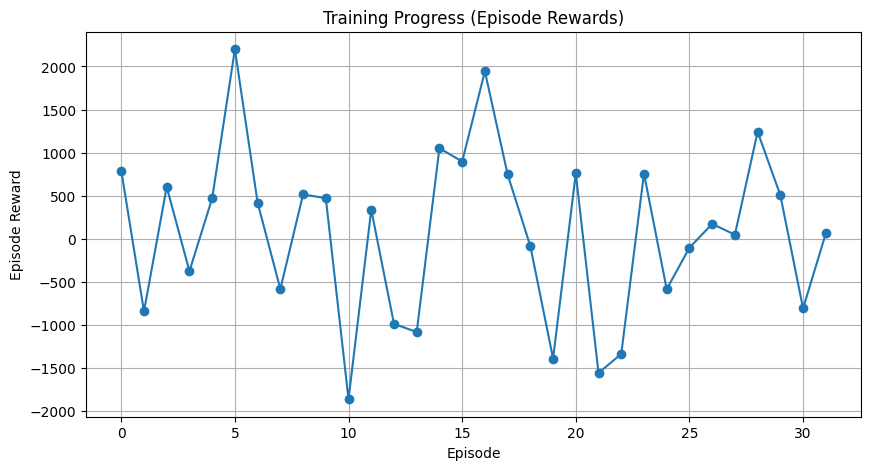

Episode 31, Reward: 62.29


KeyboardInterrupt: 

In [7]:
from Reinforcement_learning.DRL_agent import DRLAgent, train_dqn

state_dim = env.observation_space.shape[0]  # e.g., 5
action_dim = env.action_space.n             # e.g., 3

agent = DRLAgent(state_dim, action_dim, device='cpu')
agent, episode_rewards = train_dqn(
    agent, env, num_episodes=50, target_update=5, render_training=True,
    position_sizing_fn=scale_in_position_sizing
)


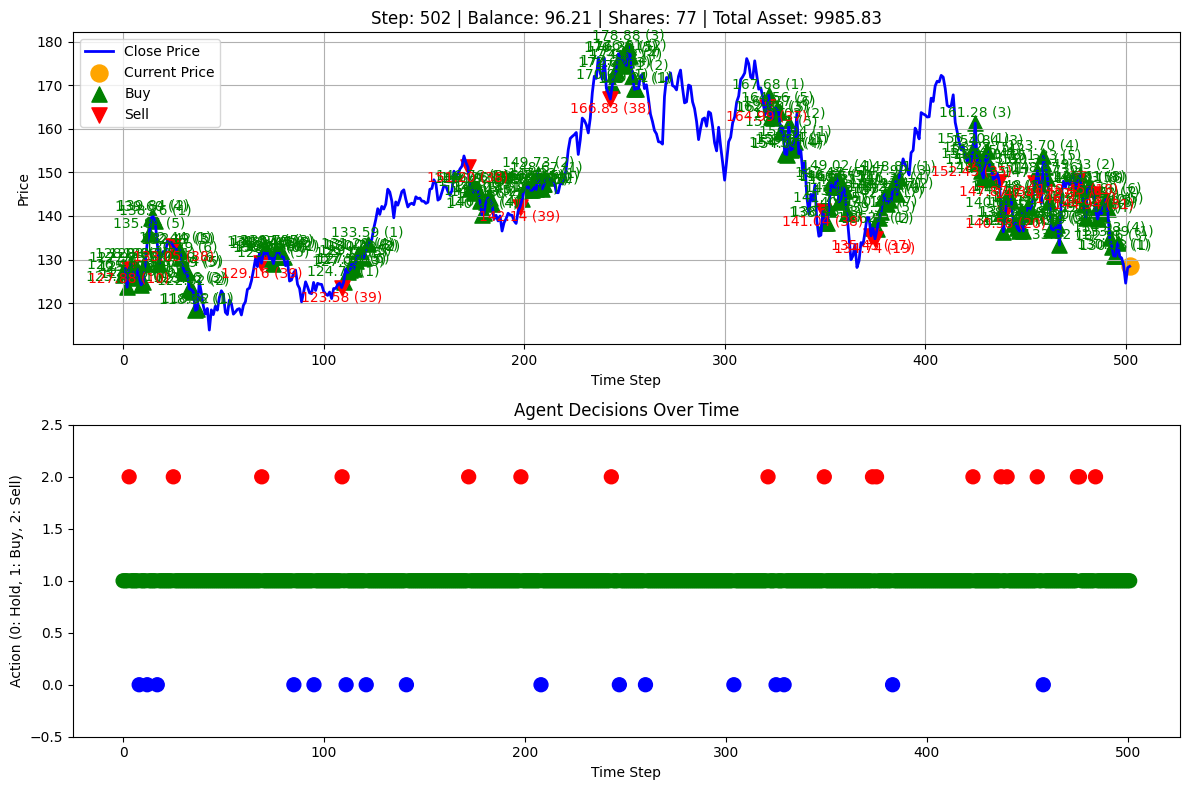

In [ ]:
obs = env.reset()
done = False
step = 0
decision_history = []  

while not done:
    # The agent selects a discrete action.
    action = agent.select_action(obs)
    
    # Use the scale-in position sizing strategy (a separate function) to get the quantity.
    quantity = scale_in_position_sizing(obs, env, action, base_fraction=0.05)
    
    # Record the decision.
    decision_history.append((env.current_step, action))
    
    # Take a step in the environment.
    obs, reward, done, info = env.step((action, quantity))
    
    # Render your real-time combined plot.
    real_time_render_with_decisions(env, decision_history)
    
    step += 1
